In [1]:
!pip install kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pankajkarki","key":"563115ce1ea9892ab835dfbe5b8acba1"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c quora-question-pairs

!ls

  0% 0.00/4.95M [00:00<?, ?B/s]
100% 4.95M/4.95M [00:00<00:00, 45.3MB/s]
 24% 5.00M/21.2M [00:00<00:01, 14.8MB/s]
100% 21.2M/21.2M [00:00<00:00, 47.6MB/s]
 98% 110M/112M [00:02<00:00, 46.8MB/s] 
100% 112M/112M [00:02<00:00, 53.1MB/s]
kaggle.json  sample_submission.csv.zip	train.csv.zip
sample_data  test.csv.zip


In [3]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [13]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import gc
import re
import time
import spacy
import sqlite3
import csv
import math

import datetime as dt
from tqdm import tqdm
from os import path
from PIL import Image

import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from mlxtend.classifier import StackingClassifier

from scipy.sparse import hstack

from sqlalchemy import create_engine # database connection

import xgboost as xgb

In [0]:
# Loading data
data = pd.read_csv("train.csv")

# [1] Exploratory Data Analysis

### [1.1] Basic stats

In [16]:
data.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


### [1.2] Distribution of data points among output classes

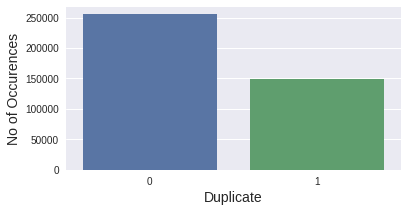

In [17]:
dup = data['is_duplicate'].value_counts()
plt.figure(figsize=(6,3))
sns.barplot(dup.index,dup.values)
plt.ylabel("No of Occurences",fontsize=14)
plt.xlabel("Duplicate",fontsize=14)
plt.show()

In [59]:
print("Question pairs are not similar that mean they are not duplicate: {}%".format(100-round(data['is_duplicate'].mean()*100,2)))
print("Question pairs are similar that means they are duplicates: {}%".format(round(data['is_duplicate'].mean()*100,2)))

Question pairs are not similar that mean they are not duplicate: 63.08%
Question pairs are similar that means they are duplicates: 36.92%


### [1.3] Number of unique questions

In [60]:
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_question = len(np.unique(qids))
question_morethan_onetimes = np.sum(qids.value_counts()>1)

print("Total numbers of unique question is {}".format(unique_question))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'
       .format(question_morethan_onetimes,question_morethan_onetimes/unique_question*100))

print ('Max number of times a single question is repeated: {}\n'.
       format(max(qids.value_counts())))

Total numbers of unique question is 537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



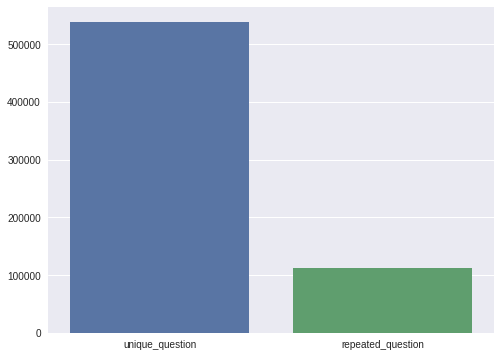

In [61]:
x = ['unique_question','repeated_question']
y = [unique_question,question_morethan_onetimes]
plt.figure(figsize=(8,6))
sns.barplot(x,y)
plt.show()

### [1.4] Number of occurrences of each question

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



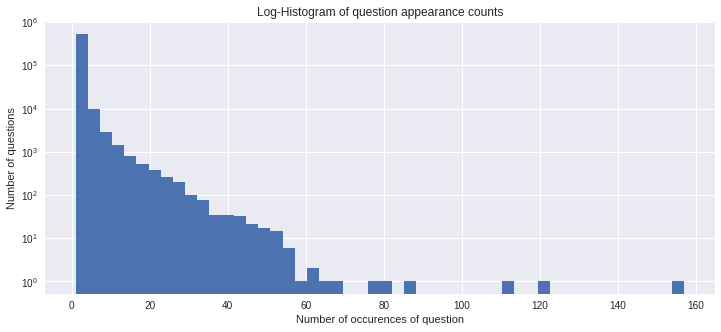

In [58]:
print('Total number of question pairs for training: {}'.format(len(data)))
print('Duplicate pairs: {}%'.format(round(data['is_duplicate'].mean()*100, 2)))
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

**In terms of questions, most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). One question appears more than 160 times, but this is an outlier.**

In [0]:
train_qs = pd.Series(data['question1'].tolist() + data['question2'].tolist()).astype(str)

(-0.5, 1439.5, 1079.5, -0.5)

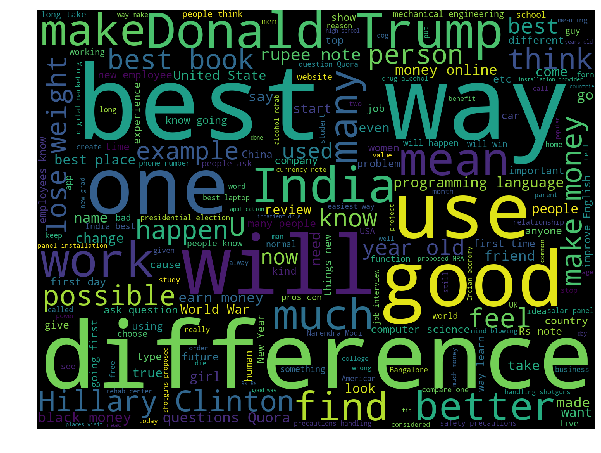

In [52]:
# So what are the most common words?
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 0, 'word_match_share')

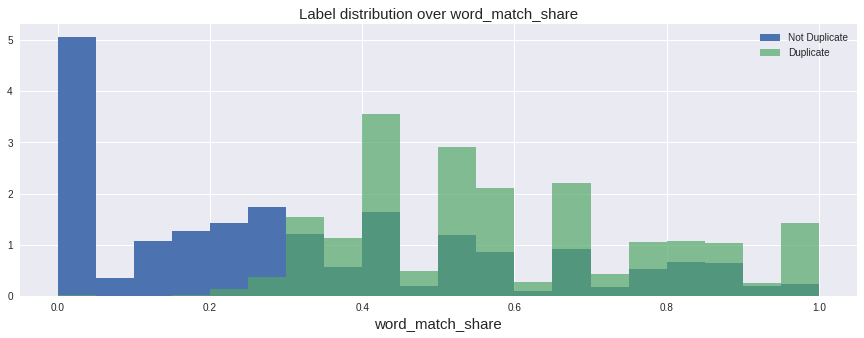

In [55]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = data.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[data['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[data['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

**Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. It seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.**

## [2] Data preprocessing

In [64]:
# Missing values
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [65]:
# Finning missing values with ""
data = data.fillna('')
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [66]:
import nltk
nltk.download('stopwords')

# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# preprocessing each question
data['question1'] = data['question1'].apply(preprocess)
data['question2'] = data['question2'].apply(preprocess)


In [0]:
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))


## [3] Spliting data

In [0]:
from sklearn.model_selection import train_test_split

X = data.drop(['is_duplicate'],axis = 1)
y = data['is_duplicate']

# Spliting data into test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## [4] TFIDF Text Featurization

In [0]:
tfidf = TfidfVectorizer(ngram_range = (1,2), min_df=3)

train_X = X_train['question1'] + X_train['question2']
train = tfidf.fit_transform(train_X)

test_X = X_test['question1'] + X_test['question2']
test = tfidf.transform(test_X)

# Normalization
train = normalize(train, axis=0)
test = normalize(test, axis=0)

In [72]:
print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (323432, 5)
Test Data Size:  (80858, 5)


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)   
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## [5] Models

### [5.1] Random model

Log loss on Test Data using Random Model 0.8886613042283535


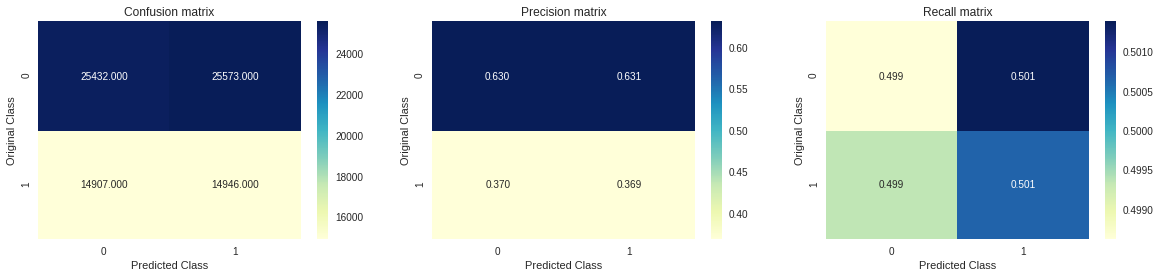

In [74]:
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### [5.2] Logistic regression

For values of alpha =  1e-05 The log loss is: 0.4994587877545407
For values of alpha =  0.0001 The log loss is: 0.5184171692424812
For values of alpha =  0.001 The log loss is: 0.521401925372735
For values of alpha =  0.01 The log loss is: 0.5254815656223314
For values of alpha =  0.1 The log loss is: 0.6168629959675148
For values of alpha =  1 The log loss is: 0.6624545760320462
For values of alpha =  10 The log loss is: 0.669268033434618


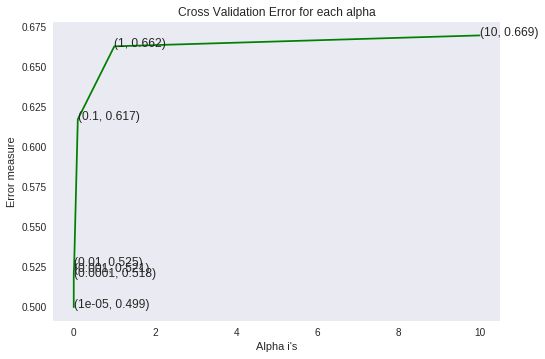

For values of best alpha =  1e-05 The train log loss is: 0.33693153383225977
For values of best alpha =  1e-05 The test log loss is: 0.4994587877545407
Total number of data points : 80858


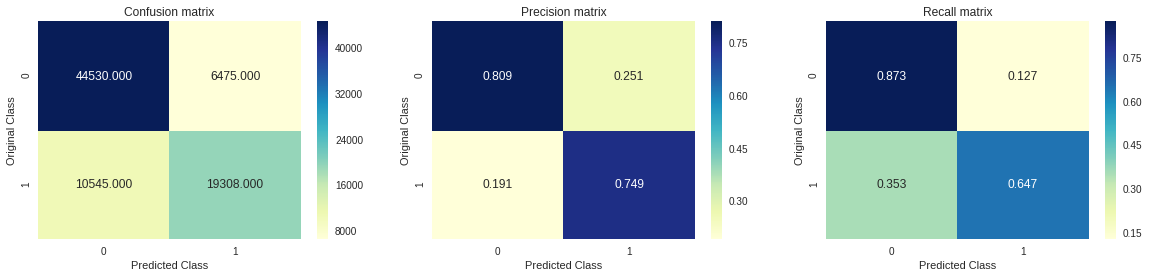

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train, y_train)
    predict_y = sig_clf.predict_proba(test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train, y_train)

predict_y = sig_clf.predict_proba(train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


### [5.3] Support Vector Machine

For values of alpha =  1e-05 The log loss is: 0.4975995804646257
For values of alpha =  0.0001 The log loss is: 0.5151227724124563
For values of alpha =  0.001 The log loss is: 0.5150589394494945
For values of alpha =  0.01 The log loss is: 0.5151789688720703
For values of alpha =  0.1 The log loss is: 0.6704930465999653
For values of alpha =  1 The log loss is: 0.6704930428619987
For values of alpha =  10 The log loss is: 0.6704930429794281


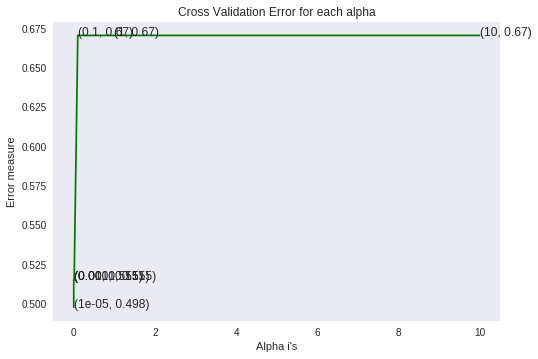

For values of best alpha =  1e-05 The train log loss is: 0.33446347008001664
For values of best alpha =  1e-05 The test log loss is: 0.4975995804646257
Total number of data points : 80858


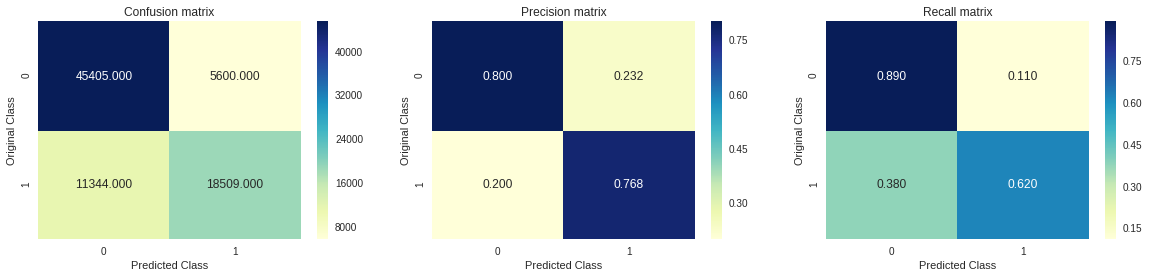

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train, y_train)
    predict_y = sig_clf.predict_proba(test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train, y_train)

predict_y = sig_clf.predict_proba(train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


### [5.4] Ensemble(XGBoost)

In [0]:
import scipy.stats as sc
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters
learning_rate = sc.uniform(0.01,0.1)
base_learners = sc.randint(10,200)
depth = sc.randint(5,10)
min_child_weight = sc.randint(5,10)

params = {'learning_rate': learning_rate, 'n_estimators':base_learners, 'max_depth':depth, 'min_child_weight':min_child_weight}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic')
gsv = RandomizedSearchCV(xgb_classifier, params, cv=3, scoring="neg_log_loss", verbose=1, random_state=0, n_jobs=-1)
gsv.fit(train,y_train)

print("Best Hyperparameter: ", gsv.best_params_)
print("Best neg_log_loss: %.2f%%",(gsv.best_score_*100))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 81.0min finished


Best Hyperparameter:  {'learning_rate': 0.0364555612104627, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 193}
Best neg_log_loss: %.2f%% -52.887716578378665


The train log loss is: 0.5183598980043103
The test log loss is: 0.6145061993974784
Total number of data points : 80858


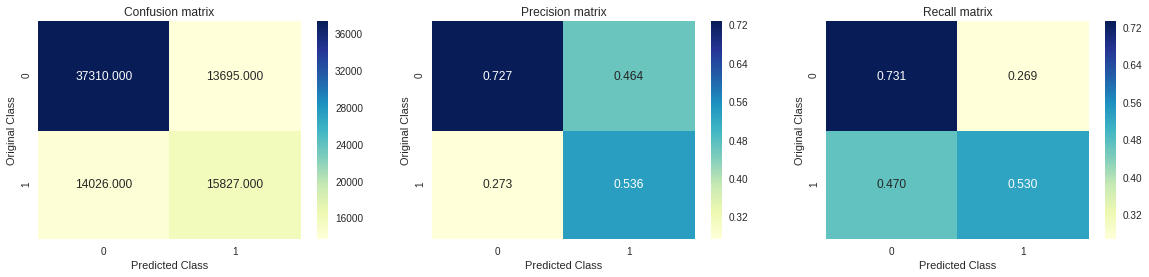

In [0]:
predict_y = gsv.predict_proba(train)
print("The train log loss is:",log_loss(y_train, predict_y, eps=1e-15))
predict_y = gsv.predict_proba(test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["FEATURIZATION", "MODEL", "TRAIN_LOSS","TEST_LOSS"]

x.add_row(["", "Logistic Regression", 0.33, 0.49])
x.add_row(["TF_IDF", "SVM", 0.33, 0.49])
x.add_row(["", "XGBoost", 0.51, 0.61])


print('\t\t\tPerformance Table')
print(x)

			Performance Table
+---------------+---------------------+------------+-----------+
| FEATURIZATION |        MODEL        | TRAIN_LOSS | TEST_LOSS |
+---------------+---------------------+------------+-----------+
|               | Logistic Regression |    0.33    |    0.49   |
|     TF_IDF    |         SVM         |    0.33    |    0.49   |
|               |       XGBoost       |    0.51    |    0.61   |
+---------------+---------------------+------------+-----------+


## Conclusion

1. Applying all the three models(LR, lr.SVM, XGBoost) withTFIDF featurization.
2. LR and lr.SVM are working pretty well in reducing log_loss
2. And even the precision and recall is also pretty good in LR and lr.SVM.

## Precedure Followed 

Pipeline
The pipeline can be seen as the plans or the processes to solve the problem. The process can be:

Raw Data ->Data Exploration Analysis -> Featurization -> Modeling -> Final Prediction

The further explanation is:

1. Raw Data: This is the first step to deal with the data. The loading process of data, data exploration analysis as well as the basic analysis will be run.
2. EDA: In this step, we explored the data and the features and did some interesting visualization to see whether the datapoints are seperable or not.
3. Features: This is the further step to explore the data. This step can also be called as feature engineering, which deals with how to construct the new features, or how to transfer the previous raw data into the features, which can be used by the models.
4. Modeling: In this part, there are two kinds of processes. Tuning hyperparameters and applying model with the optimal hyperparameters.
